## **Data Reading/ Data Understanding**


*Mounting data to google colab notebook using google drive*

In [2]:
from google.colab import drive
import pathlib
drive.mount('/content/gdrive')

Mounted at /content/gdrive


*Updating paths of train and test data*

In [3]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/Melanoma Data'
data_dir_train = pathlib.Path(root_path+"/Train")
data_dir_test = pathlib.Path(root_path+"/Test")

*Listing other important libraries*

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam

## **Dataset Creation**

*To count the number train and test size*

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


*Loading the data using "image_dataset_from_directory" module of Keras Preprocessing*

In [6]:
#the proposal is to move with 80/20 split for training and validation

#training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split =0.2,subset = "training",seed = 123, image_size = (180,180), batch_size = 32)
#validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split =0.2,subset = "validation",seed = 123, image_size = (180,180), batch_size = 32)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [18]:
onco_class = []
print("The following Oncological diseases classes have been identified:\n")
for i in range(len(train_ds.class_names)):
  print(str(i+1)+"."+train_ds.class_names[i])
  onco_class.append(train_ds.class_names[i])

The following Oncological diseases classes have been identified:

1.actinic keratosis
2.basal cell carcinoma
3.dermatofibroma
4.melanoma
5.nevus
6.pigmented benign keratosis
7.seborrheic keratosis
8.squamous cell carcinoma
9.vascular lesion


# **Dataset Visualization**

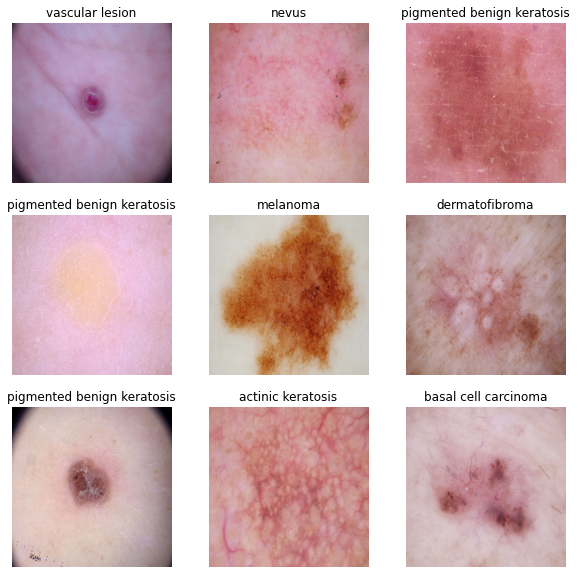

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **CNN MODEL**

*The proposal is to build a common model for all three cases and understand the accuracy change for the three cases*

In [22]:
def cnn_model():
  model = Sequential()
  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape = (180,180,3)))

  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(180,180,3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))
  model.add(Dense(9,activation = "softmax"))
  model.summary()

  return model

# **CNN MODEL 1**

Model

In [23]:
cnn1 = cnn_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 87, 87, 64)      

*Model Compiling*

In [24]:
opt = Adam(learning_rate=0.001)
cnn1.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

*Model Training*

In [25]:
%%time
cnn_model1 = cnn1.fit(train_ds,batch_size = 32, validation_data = val_ds, epochs = 20)

Epoch 1/20
56/56 [==============================] - 261s 1s/step - loss: 13.2294 - accuracy: 0.3465 - val_loss: 4.8018 - val_accuracy: 0.2170
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 3.0262 - accuracy: 0.4459 - val_loss: 9.0117 - val_accuracy: 0.1163
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.7408 - accuracy: 0.5162 - val_loss: 7.1468 - val_accuracy: 0.1320
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.2383 - accuracy: 0.6233 - val_loss: 10.9926 - val_accuracy: 0.2103
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.0532 - accuracy: 0.6590 - val_loss: 4.9551 - val_accuracy: 0.2483
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 0.7918 - accuracy: 0.7383 - val_loss: 7.1853 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 0.6892 - accuracy: 0.7952 - val_loss: 6.9093 - val_accuracy: 0.2685
Epoch 8/20


*Model Training Visualization*

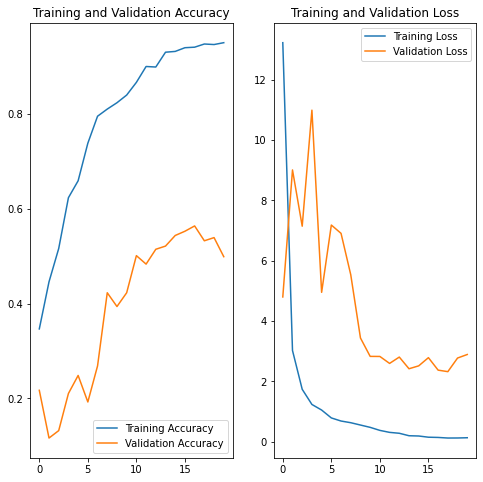

In [26]:
acc = cnn_model1.history['accuracy']
val_acc = cnn_model1.history['val_accuracy']

loss = cnn_model1.history['loss']
val_loss = cnn_model1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **CNN_Model1 Learnings**


1.   Hence from the Training and Validation Accuracy graph it is clear that the model could potentially be overfitting and there is a significant difference between the validation and training dataset.
2.   From the training loss versus validation loss graph the training loss has steadily reduced whereas there is some initial noise with the validation data set but however it plateaus out at the end.



# **CNN MODEL 2**
## Using Data Augmentation

*Leveraging ImageDataGenerator Function*

In [27]:
model_img_data_gen = ImageDataGenerator(rotation_range = 90,zoom_range = 0.2, width_shift_range = 0.5, height_shift_range  = 0.5, horizontal_flip = True, vertical_flip = True, validation_split = 0.2)

In [28]:
train_ds_aug = model_img_data_gen.flow_from_directory(data_dir_train, target_size = (180,180),classes = onco_class,batch_size = 64)
val_ds_aug = model_img_data_gen.flow_from_directory(data_dir_test, target_size = (180,180),classes = onco_class,batch_size = 64)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


*Data Visualization*

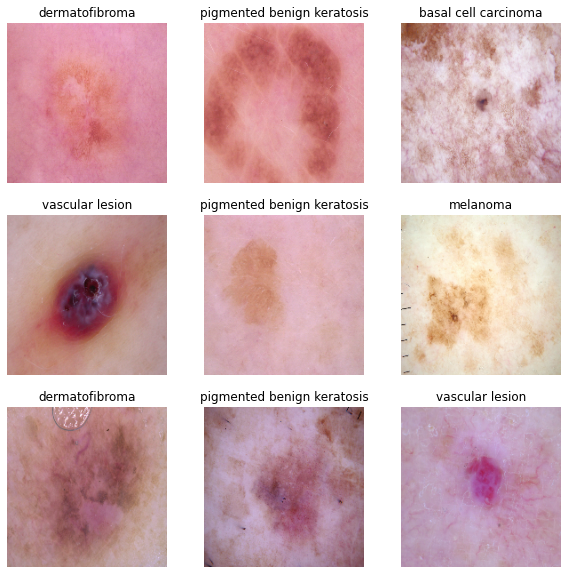

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(onco_class[labels[i]])
    plt.axis("off")

*Model*

In [30]:
cnn2 = cnn_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 87, 87, 64)      

*Model Compiling*

In [31]:
opt = Adam(learning_rate=0.001)
cnn2.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

*Model Training*

In [32]:
%%time
cnn_model2 = cnn2.fit(train_ds_aug,batch_size = 32, validation_data = val_ds_aug, epochs = 20)

Epoch 1/20
35/35 [==============================] - 108s 3s/step - loss: 18.6679 - accuracy: 0.2751 - val_loss: 3.2692 - val_accuracy: 0.1356
Epoch 2/20
35/35 [==============================] - 58s 2s/step - loss: 6.1917 - accuracy: 0.2818 - val_loss: 4.5880 - val_accuracy: 0.1356
Epoch 3/20
35/35 [==============================] - 59s 2s/step - loss: 2.3154 - accuracy: 0.3377 - val_loss: 3.1740 - val_accuracy: 0.1017
Epoch 4/20
35/35 [==============================] - 58s 2s/step - loss: 1.7505 - accuracy: 0.4020 - val_loss: 3.8037 - val_accuracy: 0.0339
Epoch 5/20
35/35 [==============================] - 58s 2s/step - loss: 1.6305 - accuracy: 0.4305 - val_loss: 8.7987 - val_accuracy: 0.0254
Epoch 6/20
35/35 [==============================] - 59s 2s/step - loss: 1.5880 - accuracy: 0.4274 - val_loss: 10.4132 - val_accuracy: 0.0508
Epoch 7/20
35/35 [==============================] - 58s 2s/step - loss: 1.5147 - accuracy: 0.4685 - val_loss: 12.8318 - val_accuracy: 0.0254
Epoch 8/20
35/35

*Model Trainging Visualization*

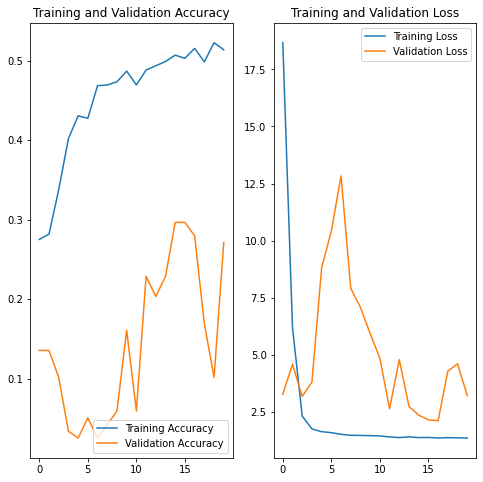

In [33]:
acc = cnn_model2.history['accuracy']
val_acc = cnn_model2.history['val_accuracy']

loss = cnn_model2.history['loss']
val_loss = cnn_model2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **CNN_Model2 With Data Augmentation Learnings**


1.   With Data Augmentation we have been able to reduce the overfitting concept - but however this has significantly affected the accuracy. The validation accuracy has also shown poor performance.
2.   The training loss has increased and there is much more instability with the validatio loss compared to the previous model.

Hence the conclusion is that there is no improvement in the model after applying data augmentation. 


# **CNN MODEL 3**


*Data Class Count Visualization*

In [7]:
img_counter = []
for i in pathlib.Path(data_dir_train).iterdir():
  if i.is_dir():
    img_counter.append(len([x for x in os.listdir(i) if os.path.isfile(os.path.join(i,x))]))

img_class = [x for x in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train,x))]

In [8]:
class_dist = pd.DataFrame(list(zip(img_class,img_counter)),columns = ["Onco Disease Class", "Number of Images"])
class_dist

,Onco Disease Class,Number of Images
0,vascular lesion,139
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,dermatofibroma,95
4,actinic keratosis,114
5,basal cell carcinoma,376
6,pigmented benign keratosis,462
7,nevus,357
8,melanoma,438


*Using Augmentor*

In [34]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/"
import Augmentor
for i in onco_class:
    p = Augmentor.Pipeline(pathlib.Path(path_to_training_dataset+str(i)))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DE28F60D0>: 100%|██████████| 500/500 [00:20<00:00, 24.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DE2485F10>: 100%|██████████| 500/500 [00:20<00:00, 23.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DE24A7C10>: 100%|██████████| 500/500 [00:21<00:00, 22.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F2DE2313C50>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F2DE2313FD0>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DE249F950>: 100%|██████████| 500/500 [00:19<00:00, 25.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F2DE249D290>: 100%|██████████| 500/500 [00:39<00:00, 12.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DE23E9A50>: 100%|██████████| 500/500 [00:17<00:00, 28.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DE23E9990>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


*Lets see the distribution of augmented data after adding new images to the original training data.*

In [41]:
path_list = list(x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
print(len(path_list))

4500


In [42]:
lesion_list_new = list(os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
print(len(lesion_list_new))

4500


In [43]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [45]:
new_df['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
dermatofibroma                500
actinic keratosis             500
basal cell carcinoma          500
pigmented benign keratosis    500
nevus                         500
melanoma                      500
Name: Label, dtype: int64

*Model DataSet Updation*

In [9]:

#training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split =0.2,subset = "training",seed = 123, image_size = (180,180), batch_size = 32)
#validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split =0.2,subset = "validation",seed = 123, image_size = (180,180), batch_size = 32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


*Model Building*

In [10]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
  
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dense(9,activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 87, 87, 64)       2

*Model Compiling*

In [11]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

*Model Training*

In [12]:
%%time
cnn_model3 = model.fit(train_ds,batch_size = 32, validation_data = val_ds, epochs = 20)

Epoch 1/20
169/169 [==============================] - 795s 4s/step - loss: 6.9783 - accuracy: 0.3800 - val_loss: 10.3235 - val_accuracy: 0.0921
Epoch 2/20
169/169 [==============================] - 33s 190ms/step - loss: 1.2686 - accuracy: 0.5929 - val_loss: 8.1551 - val_accuracy: 0.2027
Epoch 3/20
169/169 [==============================] - 33s 190ms/step - loss: 0.8036 - accuracy: 0.7274 - val_loss: 2.0156 - val_accuracy: 0.4900
Epoch 4/20
169/169 [==============================] - 34s 192ms/step - loss: 0.6936 - accuracy: 0.7582 - val_loss: 0.9686 - val_accuracy: 0.7127
Epoch 5/20
169/169 [==============================] - 34s 193ms/step - loss: 0.5808 - accuracy: 0.8019 - val_loss: 1.1982 - val_accuracy: 0.6236
Epoch 6/20
169/169 [==============================] - 33s 189ms/step - loss: 0.4745 - accuracy: 0.8407 - val_loss: 1.0490 - val_accuracy: 0.6711
Epoch 7/20
169/169 [==============================] - 33s 190ms/step - loss: 0.3835 - accuracy: 0.8624 - val_loss: 1.2896 - val_acc

*Model Training Visualization*

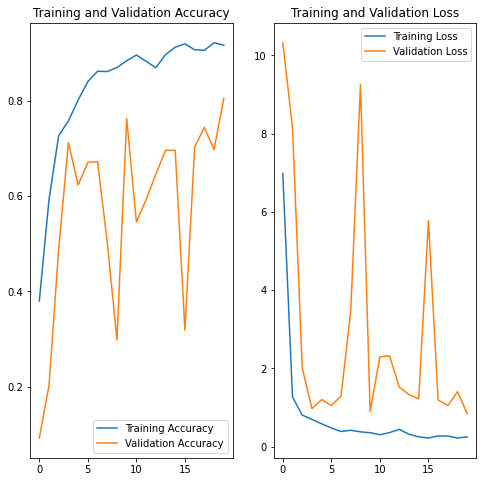

In [13]:
acc = cnn_model3.history['accuracy']
val_acc = cnn_model3.history['val_accuracy']

loss = cnn_model3.history['loss']
val_loss = cnn_model3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# CNN MODEL 3 Learning

Based on the result:


1.   The training accuracy has reduced indicating a reduction in overfitting. However the accuracy difference between the validation and training accuracy has reduced. 
2.   Both the training and validation accuracy has been decreasing however there is still large noises in the validation loss graph indicating that we might need to have better validation dataset.


# Result

*Model Graphics*

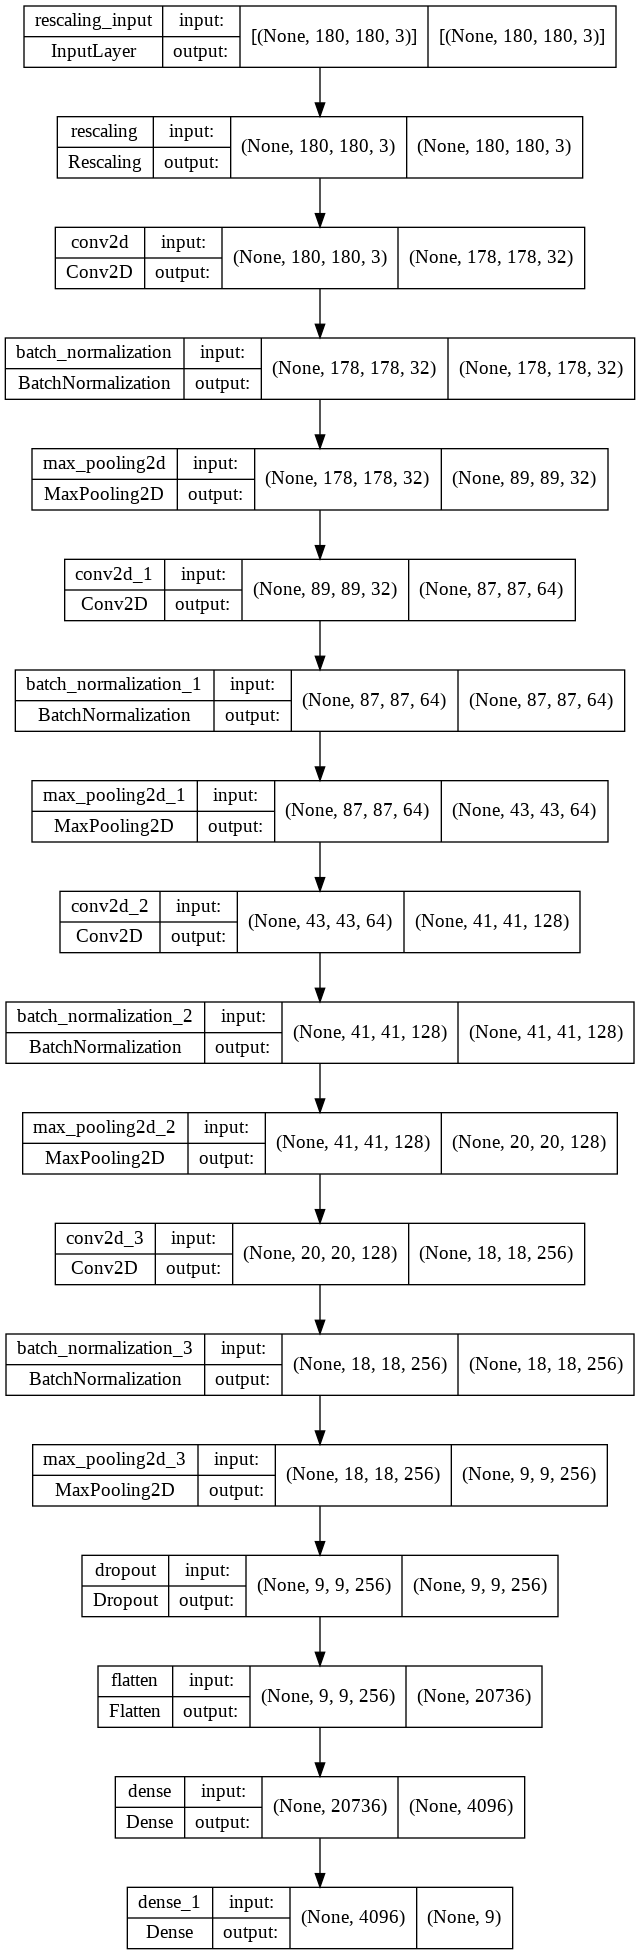

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

*Model Demo*

Prediction = melanoma
Actual = melanoma


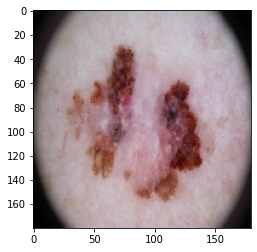

In [25]:
test = glob.glob(os.path.join(data_dir_test, onco_class[3], '*'))
test = load_img(test[6],target_size = (180,180,3))
plt.imshow(test)

test_img_model = np.expand_dims(test,axis = 0)
prediction = model.predict(test_img_model)
prediction = np.argmax(prediction)
print("Prediction = "+onco_class[prediction])
print("Actual = " + onco_class[3])